En este cuaderno, construiremos un agente que actúe como camarero de restaurante, capaz de interactuar con los clientes, responder a sus preguntas sobre el menú y proporcionar respuestas amables. Usaremos las bibliotecas LangChain y LangGraph para construir el flujo de trabajo del agente e integrarlo con los modelos de lenguaje basados en GPT de OpenAI.

### Libraries, API Keys and Data

Necesitamos instalar varias bibliotecas para construir nuestro agente:
*   langchain-community y langchain-openai: Para integraciones con modelos de lenguaje y creación de prompts.
*   unstructured: Para la carga y procesamiento de documentos.
*   faiss-cpu: Para la búsqueda de similitud vectorial.
*   langgraph: Para construir el grafo de flujo de trabajo.


In [1]:
from langchain_community.document_loaders import UnstructuredExcelLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain.schema.output_parser import StrOutputParser

from typing import List
from typing_extensions import TypedDict
from IPython.display import display, Image

from langgraph.graph import StateGraph, END

Usamos UnstructuredExcelLoader para cargar datos desde el archivo de Excel que contiene el menú del restaurante. El parámetro mode="elements" asegura que los datos se carguen como elementos individuales.


In [2]:
# Specify the path to the Excel file containing the menu
file = 'imgs/menus/Dim Sum/carta.xlsx'

# Create an instance of the loader with the specified mode
loader = UnstructuredExcelLoader(file, mode="elements")

# Load the data from the Excel file
data = loader.load()

Creamos embeddings para los datos del menú utilizando GoogleGenerativeAIEmbeddings. Chroma se utiliza para crear un almacén vectorial a partir de los documentos, lo que permite realizar búsquedas de similitud de manera eficiente.

In [3]:
import os
from json import load
from dotenv import load_dotenv

load_dotenv()  # Load environment variables from a .env file
google_api_key = os.getenv("GOOGLE_API_KEY")  # Get the Gemini API key from environment variables

In [6]:
# Create embeddings using Google Gemini embedding model
embeddings_client = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

def clean_metadata(data):
    for doc in data:
        if hasattr(doc, 'metadata'):
            for key, value in doc.metadata.items():
                if isinstance(value, (list, dict)):
                    doc.metadata[key] = str(value)
    return data

# Limpia los metadatos antes de crear el vector store
data = clean_metadata(data)

db = Chroma.from_documents(data, embeddings_client)


### Proceso

Definimos una clase personalizada TypedDict para llevar un registro del estado del agente e implementamos funciones que representan los diferentes pasos en el flujo de trabajo del agente.

AgentState almacena toda la información necesaria sobre el estado actual de la conversación.


In [7]:
# Define a TypedDict to store the agent's state
class AgentState(TypedDict):
    start: bool             # Indicates if the conversation has started
    conversation: int       # Keeps track of conversation turns
    question: str           # Customer's question
    answer: str             # Agent's answer
    topic: bool             # Decision on whether the question is appropriate
    documents: list         # Relevant documents retrieved
    recursion_limit: int    # To avoid endless loops
    memory: list            # Conversation history

In [64]:
def greetings(state):
    # Saludar al cliente
    print(f"\033[0;31m¡Hola! Bienvenido al restaurante. Seré su camarero. ¿En qué puedo ayudarle?\033[0m")

    # Capturar la entrada del usuario
    print('\n')
    user_input = input()
    print(f"\033[0;32m{user_input}\033[0m")
    print('\n')

    # Actualizar el estado con la pregunta del cliente e inicializar variables de la conversación
    state['question'] = user_input
    state['conversation'] = 1
    state['memory'] = [user_input]

    return state


Necesitamos evaluar si la pregunta del cliente es apropiada para que la responda un camarero.

In [50]:
def check_question(state):
    # Obtener la pregunta del cliente desde el estado
    question = state['question']

    # Definir el prompt del sistema para evaluar la pertinencia de la pregunta
    system_prompt = """
    Eres un evaluador que califica la pertinencia de la pregunta de un cliente a un camarero en un restaurante.
    Evalúa si la pregunta es adecuada para hacer al personal del restaurante y si el cliente muestra interés en continuar la conversación.
    Responde con "True" si la pregunta es apropiada para el personal o indica que el cliente está haciendo una pregunta o dándote información.
    De lo contrario, responde con "False".
    Proporciona solo "True" o "False" en tu respuesta.
    """

    # Crear una plantilla de prompt para el formato
    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "Pregunta del usuario: {question}"),
    ])

    # Formatear el prompt con la pregunta del cliente
    prompt = TEMPLATE.format(question=question)

    # Inicializar el modelo de lenguaje
    model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", api_key=google_api_key)

    # Invocar el modelo con el prompt
    response_text = model.invoke(prompt)

    # Actualizar el estado con la decisión del modelo
    state['topic'] = response_text.content.strip()

    return state


Esta función dirige el flujo de trabajo según si la pregunta está relacionada con el tema o no.

In [51]:
# Function to check if the LLM model decides if the question is on topic on top
def topic_router(state):
  topic = state['topic']
  if topic == "True":
    return "on_topic"
  else:
    return "off_topic"

Proporciona una respuesta adecuada si la pregunta del cliente no está relacionada con el tema.

In [68]:
def off_topic_response(state):
    # Verificar si es el primer turno de conversación
    if state['conversation'] <= 1:
        state['answer'] = "\nLo siento, no puedo responder esa pregunta. Solo puedo responder preguntas sobre el menú de este restaurante."
    else:
        state['answer'] = "\nEncantado de ayudar."
    print(f"\033[0;31m{state['answer']}\033[0m")

Si la pregunta está relacionada con el tema, recuperamos documentos relevantes y generamos una respuesta utilizando el modelo de lenguaje.

**Recuperar documentos relevantes**
Usamos el historial de la conversación para recuperar los elementos del menú más relevantes. similarity_search encuentra los documentos más pertinentes.


In [53]:
def retrieve_docs(state):
    # Combine the conversation history into a single string
    memory = " ".join(state['memory'])

    # Retrieve the top 5 relevant documents based on similarity to the conversation history
    docs_chroma = db.similarity_search(memory, k=5)

    # Store the retrieved documents' content in the state
    state['documents'] = [doc.page_content for doc in docs_chroma]

    return state

Genera una respuesta inicial a la pregunta del cliente utilizando el modelo de lenguaje.


In [74]:
def generate(state):
    # Inicializar el modelo de lenguaje
    model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", api_key=google_api_key)

    # Extraer la información necesaria del estado
    question = state['question']
    documents = state['documents']
    memory = state['memory']

    # Definir el prompt del sistema para el camarero
    system_prompt = """
    Eres un camarero en un restaurante encargado de responder las preguntas de los clientes sobre el menú.
    Responde la pregunta como lo haría un camarero, evitando ser demasiado extenso o demasiado breve.
    No incluyas la palabra "camarero" ni te refieras a ti mismo explícitamente en tu respuesta.
    La información sobre platos y bebidas con sus precios es la proporcionada en los documentos recuperados.
    No te inventes platos ni precios que no estén en esos documentos.
    """

    # Crear una plantilla de prompt para el formato
    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "Contexto: {documents}\nHistorial de la conversación hasta ahora: {memory}\nPregunta del cliente: {question}"),
    ])

    # Formatear el prompt con los documentos recuperados, el historial de la conversación y la pregunta del cliente
    prompt = TEMPLATE.format(documents=documents, memory=memory, question=question)

    # Invocar el modelo para generar una respuesta
    response_text = model.invoke(prompt)

    # Almacenar la respuesta generada en el estado
    state["answer"] = response_text.content.strip()
    #print(f"\033[0;32m{state['answer']}\033[0m")

    return state


Refinamos la respuesta generada para asegurarnos de que sea apropiada, amable y profesional.

In [82]:
def improve_answer(state):
    # Extraer la información necesaria del estado
    question = state['question']
    answer = state['answer']
    memory = state['memory']

    # Definir el prompt del sistema para refinar la respuesta
    system = """
    Como camarero, revisa y mejora la respuesta a la pregunta de un cliente. Tu tarea es:

    1. Asegurarte de que la respuesta sea apropiada, amable e informativa.
    2. Editar o eliminar partes de la respuesta según sea necesario, sin agregar información nueva.
    3. Mantener un tono educado, profesional y atento.
    4. Proporcionar solo la respuesta mejorada, sin frases introductorias ni comentarios.
    5. Concluir la respuesta con una pregunta abierta para invitar a más consultas o atender otras necesidades.
    6. Considerar el historial de la conversación para ser más informativo y útil.
    7. Incluir saltos de línea (`\n`) al final de cada oración o pausa lógica.
    8. No abrumar al cliente con demasiada información. Debe ser concisa, relevante y precisa.
    9. Acortar la respuesta si tiene demasiados datos.
    10. Los precios sólo se dan si el cliente pregunta por ellos.

    Entrega una respuesta refinada que mejore la experiencia del cliente y refleje el compromiso del restaurante con el servicio al cliente.
    """

    # Crear una plantilla de prompt para el formato
    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", "Pregunta del cliente: {question}\nHistorial de la conversación: {memory}\nRespuesta inicial del camarero: {answer}"),
    ])

    # Inicializar el modelo de lenguaje
    model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", api_key=google_api_key)

    # Formatear el prompt con la información necesaria
    prompt = TEMPLATE.format(question=question, memory=memory, answer=answer)

    # Invocar el modelo para mejorar la respuesta
    response_text = model.invoke(prompt)

    # Actualizar el estado con la respuesta mejorada
    state['answer'] = response_text.content.strip()

    # Mostrar la respuesta mejorada
    print('\n')
   
    print(f"\033[0;31m{state['answer']}\033[0m")

    # Agregar la respuesta mejorada al historial de la conversación
    state['memory'].append(state['answer'])

    return state


Permite que el cliente haga preguntas adicionales y actualiza el estado de la conversación en consecuencia.

In [65]:
def further_question(state):
    # Prompt the customer for further input
    print('\n')
    user_input = input()
    print(f"\033[0;32m{user_input}\033[0m")
    print('\n')
    
    # Update the state with the new question and increment the conversation turn
    state['question'] = user_input
    state['conversation'] += 1
    state['memory'].append(user_input)

    return state

### Workflow

Usamos StateGraph para definir el flujo de trabajo del agente, conectando las funciones que hemos definido.

**Inicializar StateGraph**
StateGraph ayuda a definir el flujo del estado del agente a través de las diferentes funciones.


In [83]:
# Initialize a StateGraph with the AgentState type
workflow = StateGraph(AgentState)

# Add the functions as nodes in the workflow
workflow.add_node("greetings", greetings)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("check_question", check_question)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("generate", generate)
workflow.add_node("improve_answer", improve_answer)
workflow.add_edge("generate", "improve_answer")
workflow.add_node("further_question", further_question)

# Set the entry point of the workflow to the greetings function
workflow.set_entry_point("greetings")

# Add conditional edges based on the topic_router function's output
workflow.add_conditional_edges(
    "check_question",
    topic_router,
    {
        "on_topic": "retrieve_docs",
        "off_topic": "off_topic_response"
    }
)

# Define the sequence of steps in the workflow
workflow.add_edge("greetings", "check_question")
workflow.add_edge("retrieve_docs", "generate")
workflow.add_edge("generate", "improve_answer")
workflow.add_edge("improve_answer", "further_question")
workflow.add_edge("further_question", "check_question")

# Connect the off_topic_response node to the end of the workflow
workflow.add_edge("off_topic_response", END)


# Compile the workflow into an application
app = workflow.compile()


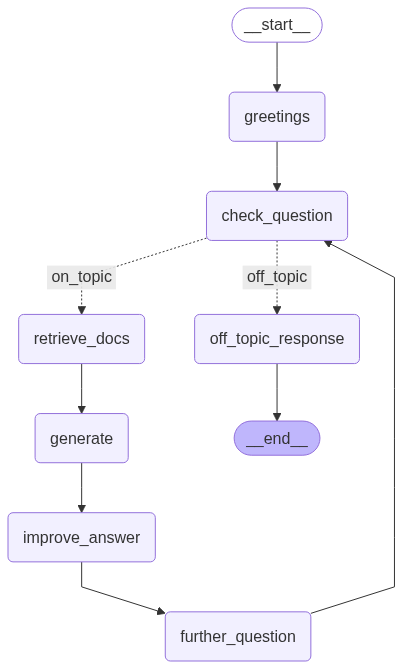

In [44]:
# Display the workflow graph for visualization
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [85]:
# Invoke the application with the initial state
result = app.invoke({"start": True}, {"recursion_limit": 50})

¡Hola! Bienvenido al restaurante. Seré su camarero. ¿En qué puedo ayudarle?


Hola




¡Hola! ¿En qué puedo ayudarle hoy?


Quiero comprar un coche



Encantado de ayudar.
